In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import regularizers

In [2]:
import pandas as pd
df = pd.read_csv("/kaggle/input/bnreel/train.csv")
tdf = pd.read_csv("/kaggle/input/bnreel/test.csv")
df

,file_id,text,source,category,class
0,3562022343909810991_63576812758,[NULL],Instagram,Safe,Safe
1,956326452811210,আমেরিকার ছাত্র আন্দোলন দমনের একটা দুর্লভ ফুটেজ,Facebook,Unsafe,Harmful
2,1621007965265006,গ্রামের সুন্দরী মেয়েদের সুন্দর ড্যান্স,Facebook,Unsafe,Adult
3,3382687520997377089_66846781731,[NULL],Instagram,Unsafe,Adult
4,507863908972262,ছেলেটার আজ আর বাড়ী যাওয়া হল না ময়মনসিংহ,Facebook,Safe,Safe
...,...,...,...,...,...
1531,1055274349411417,"শক্তি নাইরে বুড়ার গায়ে, তেল মাখতে হয় পায়ে। ওরে...",Facebook,Unsafe,Adult
1532,854716976272203,[NULL],Facebook,Safe,Safe
1533,3552382770196940051_63576812758,[NULL],Instagram,Safe,Safe
1534,6758856234238228,[NULL],Facebook,Unsafe,Adult


In [3]:
id2label = {
    "Safe": 0,
    "Unsafe": 1
}

In [4]:
df['category'] = df['category'].map(id2label)
tdf['category'] = tdf['category'].map(id2label)

In [5]:
dir1 = "/kaggle/input/bnreel/Audio_V1/Audio_V1"
dir2 = "/kaggle/input/bnreel/Audio_V2/Audio_V2"
dir3 = "/kaggle/input/bnreel/UNBER_IG/UNBER_IG/Audio_IG"

In [6]:
pip install noisereduce --quiet

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import numpy as np
import pandas as pd
import librosa
import noisereduce as nr
import soundfile as sf

In [8]:
def process_audio_file(file_path, target_length=5, sample_rate=22050, n_mfcc=13, n_chroma=12, 
                       n_spectral_contrast=6, target_length_features=20):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=sample_rate)

    # Trim or pad audio to target length
    target_samples = target_length * sr
    if len(audio) > target_samples:
        audio = audio[:target_samples]  # Trim
    else:
        padding = target_samples - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')  # Pad with silence

    # Normalize audio (zero mean, unit variance)
    mean = np.mean(audio)
    std = np.std(audio)
    safe_std = max(std, 1e-8)  # Avoid division by zero
    audio = (audio - mean) / safe_std

    # Apply noise reduction
    reduced_noise_audio = nr.reduce_noise(y=audio, sr=sr)

    if not np.isfinite(reduced_noise_audio).all():
        print("Warning: Noise reduction produced NaN/Inf values, reverting to original audio.")
        reduced_noise_audio = audio  # Use original if noise reduction fails
    
    reduced_noise_audio = np.nan_to_num(reduced_noise_audio)

    # Feature Extraction
    def truncate_or_pad(feature, target_length_features):
        """Ensures features have a fixed length by truncating or padding."""
        if feature.shape[1] > target_length_features:
            return feature[:, :target_length_features]
        else:
            return np.pad(feature, ((0, 0), (0, target_length_features - feature.shape[1])), mode='constant')

    # Extract MFCCs (13 coefficients)
    mfcc = librosa.feature.mfcc(y=reduced_noise_audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = truncate_or_pad(mfcc, target_length_features)

    # Extract Chroma Features (12 pitch classes)
    chroma = librosa.feature.chroma_stft(y=reduced_noise_audio, sr=sr, n_chroma=n_chroma)
    chroma = truncate_or_pad(chroma, target_length_features)

    # Extract Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=reduced_noise_audio, sr=sr)
    spectral_centroid = truncate_or_pad(spectral_centroid, target_length_features)

    # Extract Spectral Contrast (6 bands)
    spectral_contrast = librosa.feature.spectral_contrast(y=reduced_noise_audio, sr=sr, n_bands=n_spectral_contrast)
    spectral_contrast = truncate_or_pad(spectral_contrast, target_length_features)

    # Extract Spectrogram (Magnitude Spectrogram)
    spectrogram = np.abs(librosa.stft(reduced_noise_audio))
    spectrogram = truncate_or_pad(spectrogram, target_length_features)

    # Flatten all features into a single vector
    feature_vector = np.concatenate([
        mfcc.flatten(),
        chroma.flatten(),
        spectral_centroid.flatten(),
        spectral_contrast.flatten(),
        spectrogram.flatten()
    ])

    return feature_vector

In [9]:
scaler = StandardScaler()

In [19]:
def extract(df1):
    X = []
    y = []
    for _, row in df1.iterrows():
        reel_id = row["file_id"]
        label = row["category"]  
    
        for dir in list([dir1, dir2, dir3]):
            audio_file = os.path.join(dir, f"{reel_id}.wav")
            if os.path.exists(audio_file): 
                processed_audio = process_audio_file(audio_file)      
                X.append(processed_audio)
                y.append(label)

    Xn = np.array(X, dtype=np.float32)
    yn = np.array(y)
    Xf = scaler.fit_transform(Xn)
    Xe = np.expand_dims(Xf, axis=-1)
    print(f'Final Shape: {Xe.shape}, {yn.shape}')
    return Xe, yn

In [20]:
X, y = extract(df)

/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: divide by zero encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Final Shape: (1522, 21160, 1), (1522,)


In [21]:
X_test, y_test = extract(tdf)

/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: divide by zero encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Final Shape: (383, 21160, 1), (383,)


In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1),
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # binary
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [26]:
model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=4,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.5038 - loss: 1.6687 - val_accuracy: 0.5639 - val_loss: 2.0143 - learning_rate: 1.0000e-05
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6761 - loss: 1.0697 - val_accuracy: 0.5541 - val_loss: 1.2466 - learning_rate: 1.0000e-05
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7581 - loss: 0.9879 - val_accuracy: 0.5639 - val_loss: 1.3175 - learning_rate: 1.0000e-05
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7980 - loss: 0.9163 - val_accuracy: 0.5475 - val_loss: 1.3393 - learning_rate: 1.0000e-05
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8438 - loss: 0.8316 - val_accuracy: 0.5148 - val_loss: 1.4810 - learning_rate: 1.0000e-05
Epoch 6/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8349 - loss: 0.8269 - val_accuracy: 0.5541 - val_loss: 1.3658 - learning_rate: 1.0000e-05
Epoch 7/50
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - ac

In [27]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.6107 - loss: 1.2524
Test Accuracy: 0.5979


In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred >= 0.5).astype(int)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [30]:
y_pred_classes = y_pred_classes.flatten()

In [31]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.58      0.37      0.45       171
           1       0.61      0.78      0.68       212

    accuracy                           0.60       383
   macro avg       0.59      0.58      0.57       383
weighted avg       0.59      0.60      0.58       383



In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

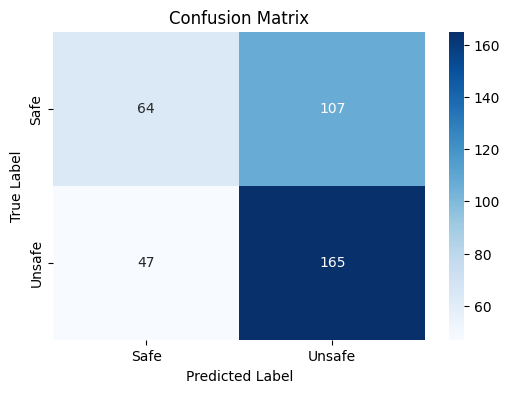

In [33]:
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=id2label.keys(), yticklabels=id2label.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

In [34]:
model.save('/kaggle/working/cnn_h1.keras')